| MODE      | Magnet stack | Distance [mm] | Max U at breakdown [V] |
| --------- | ------------ | ------------- | ---------------------- |
| Repulsion | 1            | 82            | 7.15                   |
| Repulsion | 1            | 82            | 7.41                   |
| Repulsion | 2            | 82            | 8.73                   |
| Repulsion | 2            | 82            | 10.40                  |
| Repulsion | 2            | 82            | 10.51                  |
| Repulsion | 3            | 82            | 12.36                  |
| Repulsion | 3            | 82            | 13.07                  |
| Repulsion | 1            | 85            | 5.63                   |
| Repulsion | 1            | 85            | 5.58                   |
| Repulsion | 1            | 85            | 6.60                   |
| Repulsion | 2            | 85            | 10.95                  |
| Repulsion | 2            | 85            | 9.89                   |
| Repulsion | 2            | 83.5          | 10.26                  |
| Repulsion | 2            | 83.5          | 11.3                   |
| Repulsion | 2            | 83.5          | 10.37                  |
| Repulsion | 3            | 85            | 12.97                  |
| Repulsion | 3            | 85            | 13.13                  |
| Repulsion | 1            | 87            | 5.36                   |
| Repulsion | 1            | 87            | 5.76                   |
| Repulsion | 2            | 87            | 8.72                   |
| Repulsion | 2            | 87            | 8.33                   |
| Repulsion | 2            | 87            | 8.39                   |
| Repulsion | 3            | 87            | 9.86                   |
| Repulsion | 3            | 87            | 8.91                   |
| Repulsion | 2            | 92            | 5.15                   |
| Repulsion | 2            | 92            | 5.70                   |
| Repulsion | 2            | 92            | 4.63                   |
| Repulsion | 3            | 92            | 6.31                   |
| Repulsion | 3            | 92            | 6.99                   |


In [157]:
import math
import matplotlib.pyplot as plt
import matplotlib.lines as mpl_lines
import numpy as np

%matplotlib widget

# code modified to change negative values to positive ones
def lmap(f,x):
    return list(map(f,x))

def lfilter(f,x):
    return list(filter(f,x))

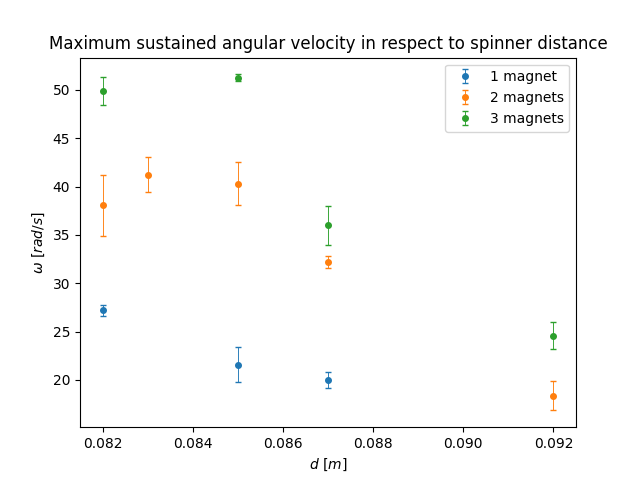

In [158]:
data = {
    1: {
        "U": [7.15, 7.41, 5.63, 5.58, 6.60, 5.36, 5.76],
        "r": [82, 82, 85, 85, 85, 87, 87],
    },
    2: {
        "U": [
            8.73,
            10.40,
            10.51,
            10.95,
            9.89,
            10.26,
            11.3,
            10.37,
            8.72,
            8.33,
            8.39,
            5.15,
            5.70,
            4.63,
        ],
        "r": [82, 82, 82, 85, 85, 83, 83, 83, 87, 87, 87, 92, 92, 92],
    },
    3: {
        "U": [12.36, 13.07, 12.97, 13.13, 9.86, 8.91, 6.31, 6.99],
        "r": [82, 82, 85, 85, 87, 87, 92, 92],
    },
}

drill_func = lambda U: 4.1728 * U + -3.1915
uniques = {}

for k in data.keys():
    datax = lmap(lambda x: x / 1000, data[k]["r"])
    datay = lmap(drill_func, data[k]["U"])
    unique = {"x": [], "y": [], "yerr": [], "U": []}

    for x in set(datax):
        Us = lmap(
            lambda i: data[k]["U"][i], lfilter(lambda i: x == datax[i], range(len(datax)))
        )
        ys = lmap(
            lambda i: datay[i], lfilter(lambda i: x == datax[i], range(len(datax)))
        )
        unique["x"].append(x)
        y_avg = np.average(ys)
        unique["y"].append(y_avg)
        unique["yerr"].append(np.average(lmap(lambda y: abs(y - y_avg), ys)))
        
        unique["U"].append(np.average(Us))

    (_, caps, _) = plt.errorbar(
        unique["x"],
        unique["y"],
        unique["yerr"],
        fmt="o",
        markersize=4,
        capsize=2,
        elinewidth=0.65,
        label = f"{k} magnet{'s' if k > 1 else ''}"
    )
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    uniques[k] = unique

plt.title("Maximum sustained angular velocity in respect to spinner distance")
plt.ylabel("$\omega$ $[rad/s]$")
plt.xlabel("$d$ $[m]$")
plt.legend()

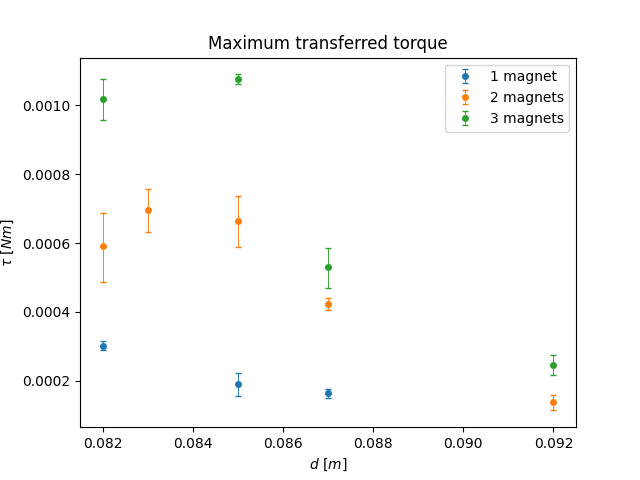

In [159]:
def torque(omeg):
    return 4.09201492e-07 * omeg ** 2

plt.figure()
for k in data.keys():
    torques = lmap(torque, uniques[k]["y"])
    (_, caps, _) = plt.errorbar(
        uniques[k]["x"],
        torques,
        yerr=[
            lmap(lambda i: abs(torque(uniques[k]["y"][i] + uniques[k]["yerr"][i]) - torques[i]), range(len(uniques[k]["y"]))),
            lmap(lambda i: abs(torque(uniques[k]["y"][i] - uniques[k]["yerr"][i]) - torques[i]), range(len(uniques[k]["y"])))
        ],
        fmt="o",
        markersize=4,
        capsize=2,
        elinewidth=0.65,
        label = f"{k} magnet{'s' if k > 1 else ''}"
    )
    for cap in caps:
        cap.set_markeredgewidth(1)
        

plt.title("Maximum transferred torque")
plt.ylabel("$\\tau$ $[Nm]$")
plt.xlabel("$d$ $[m]$")
plt.legend()

[0.32133615 0.33344548 0.33010484]


ValueError: 'yerr' (shape: (2, 3, 3)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (3,))

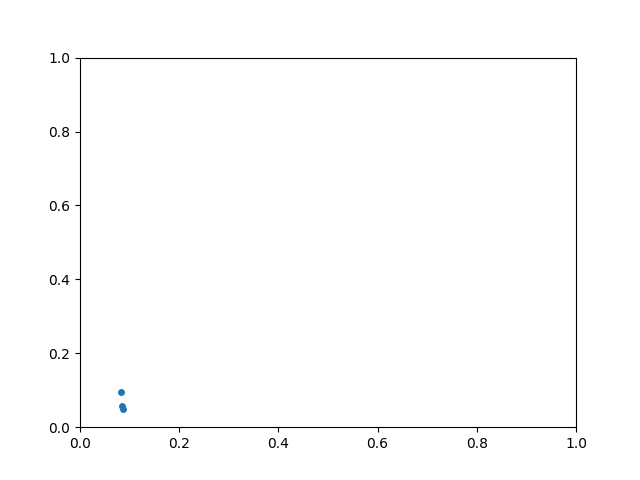

In [160]:
import scipy.optimize as opt

def torque(omeg):
    return 4.09201492e-07 * omeg ** 2

I = 4.525e-5

cols = [
    "",
    "tab:blue",
    "tab:green",
    "tab:red",
]

plt.figure()
for k in data.keys():
    torques = lmap(torque, uniques[k]["y"])
    in_torque = (np.array(uniques[k]["U"]) * 1.2) / uniques[k]["y"] # approximately the current
    print(in_torque)
    
    (_, caps, _) = plt.errorbar(
        uniques[k]["x"],
        torques / in_torque * 100,
        # yerr=[
        #     lmap(lambda i: 100 * abs(torque(uniques[k]["y"][i] + uniques[k]["yerr"][i]) - torques[i]) / in_torque, range(len(uniques[k]["y"]))),
        #     lmap(lambda i: 100 * abs(torque(uniques[k]["y"][i] - uniques[k]["yerr"][i]) - torques[i]) / in_torque, range(len(uniques[k]["y"])))
        # ],
        fmt="o",
        c = cols[k],
        markersize=4,
        capsize=2,
        elinewidth=0.65,
        label = f"{k} magnet{'s' if k > 1 else ''}"
    )
    for cap in caps:
        cap.set_markeredgewidth(1)
        
    sp_r = 0.041
    def f(x, r_0, k, l):
        return k / (l * np.sqrt(r_0 ** 2 + (x - 2*sp_r) ** 2)) ** 2
    
    popt, pcov = opt.curve_fit(
        f,
        uniques[k]["x"],
        torques / in_torque * 100,
        bounds=(
            [0, 0, 0],
            [1, 100, math.inf]
        ),
        maxfev = 100000
        
    )
    print(cols, k)
    plt.plot(
        np.linspace(0.082, 0.092, 100),
        lmap(lambda x: f(x, popt[0], popt[1], popt[2]), np.linspace(0.082, 0.092, 100)),
        c = cols[k],
        linestyle = "--",
        label = f"Fit {k} magnet{'s' if k > 1 else ''}"
    )
        

plt.title("Torque transfer efficiency")
plt.ylabel("$\\eta$ $[\%]$")
plt.xlabel("$d$ $[m]$")
plt.legend()